In [2]:
# =====================================
# 1. Import Libraries
# =====================================
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalAveragePooling1D, Attention
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import glob
import re
import string

In [3]:
# =====================================
# 2. Extract Dataset from ZIP
# =====================================
import zipfile
import os

zip_path = '/content/drive/MyDrive/Colab Notebooks/archive.zip'   # Path to ZIP file
extract_dir = '/content/data'             # Directory to extract

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Files extracted:")
print(os.listdir(extract_dir)[:10])  # Show first 10 files

✅ Files extracted:
['organization.csv', 'independent-contractor.csv', 'registration-rights.csv', 'amendments-and-waivers.csv', 'term-of-employment.csv', 'indebtedness.csv', 'transfer.csv', 'now-therefore.csv', 'time.csv', 'r-e-c-i-t-a-l-s.csv']


In [4]:
# =====================================
# 3. Load and Merge Dataset
# =====================================
files = glob.glob(os.path.join(extract_dir, '*.csv'))
dfs = [pd.read_csv(f) for f in files]
df = pd.concat(dfs, ignore_index=True)

print("✅ Dataset loaded. Sample:")
df.head()


✅ Dataset loaded. Sample:


,clause_text,clause_type
0,Organization. Buyer is a corporation duly orga...,organization
1,Organization. Buyer is a corporation duly orga...,organization
2,Organization. The Company and each of its Subs...,organization
3,Organization. The Company is a corporation dul...,organization
4,Organization. ZiaSun is a corporation duly org...,organization


In [8]:
# =====================================
# 4. Text Preprocessing
# =====================================
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'\n',' ', text)
    text = re.sub(r'\[[0-9]*\]',' ', text)
    text = re.sub(r'\d+','', text)
    text = text.translate(str.maketrans('','',string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['clause_text'].apply(preprocess_text)
print(" Preprocessing done")
df[['clause_text','clean_text']].head()


 Preprocessing done


,clause_text,clean_text
0,Organization. Buyer is a corporation duly orga...,organization buyer is a corporation duly organ...
1,Organization. Buyer is a corporation duly orga...,organization buyer is a corporation duly organ...
2,Organization. The Company and each of its Subs...,organization the company and each of its subsi...
3,Organization. The Company is a corporation dul...,organization the company is a corporation duly...
4,Organization. ZiaSun is a corporation duly org...,organization ziasun is a corporation duly orga...


In [11]:
import random

# =====================================
# 5.  Clause Pair Generation
# =====================================
def generate_pairs(df, max_similar_per_cat=20, non_similar_per_clause=1):
    """
    Generator for clause pairs (memory-efficient).
    """
    categories = df['clause_type'].unique()
    df_groups = {cat: df[df['clause_type']==cat]['clean_text'].tolist() for cat in categories}

    for cat in categories:
        texts = df_groups[cat]

        # Similar pairs
        for _ in range(min(max_similar_per_cat, len(texts)*(len(texts)-1)//2)):
            a, b = random.sample(texts, 2)
            yield (a, b), 1

        # Non-similar pairs
        other_texts = [t for c in categories if c!=cat for t in df_groups[c]]
        for text in texts:
            for _ in range(non_similar_per_clause):
                o_text = random.choice(other_texts)
                yield (text, o_text), 0

# Generate all pairs into lists (memory-safe)
pairs_list = []
labels_list = []
for (a,b), label in generate_pairs(df, max_similar_per_cat=20, non_similar_per_clause=1):
    pairs_list.append([a,b])
    labels_list.append(label)

pairs = np.array(pairs_list, dtype=object)
labels = np.array(labels_list)

# ✅ Print breakdown
print(f"✅ Total clause pairs: {len(pairs)}")
print(f"✅ Similar: {np.sum(labels==1)}, Non-similar: {np.sum(labels==0)}")

✅ Total clause pairs: 158781
✅ Similar: 7900, Non-similar: 150881


In [12]:
# =====================================
# 7. Train-Test Split
# =====================================
X_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, random_state=42, stratify=labels)
print(" Train-Test split done:", X_train.shape, X_test.shape)

 Train-Test split done: (127024, 2) (31757, 2)


In [15]:
# =====================================
# 7. Tokenization & Padding
# =====================================
all_texts = list(X_train[:,0]) + list(X_train[:,1])
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(all_texts)

max_len = 100

def preprocess_pairs(pairs):
    seq1 = tokenizer.texts_to_sequences(pairs[:,0])
    seq2 = tokenizer.texts_to_sequences(pairs[:,1])
    seq1 = pad_sequences(seq1, maxlen=max_len, padding='post')
    seq2 = pad_sequences(seq2, maxlen=max_len, padding='post')
    return seq1, seq2

X1_train, X2_train = preprocess_pairs(X_train)
X1_test, X2_test = preprocess_pairs(X_test)

In [20]:
# =====================================
# 8. Define Models
# =====================================

from tensorflow.keras.layers import Lambda

# ---------- Model 1: BiLSTM Siamese ----------
def create_bilstm_model(vocab_size=10000, embed_dim=128, lstm_units=64):
    input1 = Input(shape=(max_len,))
    input2 = Input(shape=(max_len,))

    embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len)
    lstm = Bidirectional(LSTM(lstm_units, return_sequences=False))

    x1 = lstm(embedding(input1))
    x2 = lstm(embedding(input2))

    # Wrap TF ops in Lambda layers
    diff = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([x1, x2])
    mul = Lambda(lambda tensors: tensors[0] * tensors[1])([x1, x2])

    merged = tf.keras.layers.concatenate([x1, x2, diff, mul])
    dense = Dense(64, activation='relu')(merged)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

bilstm_model = create_bilstm_model()
bilstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 100, 128)  │  1,280,000 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │     98,816 │ embedding_3[0][0… │
│ (Bidirectional)     │                   │            │ embedding_3[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ bidirectional_3[… │
│                     │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ bidirectional_3[… │
│                     │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ bidirectional_3[… │
│ (Concatenate)       │                   │            │ bidirectional_3[… │
│                     │                   │            │ lambda[0][0],     │
│                     │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     32,832 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,411,713 (5.39 MB)

 Trainable params: 1,411,713 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.layers import Lambda

# ---------- Model 2: Attention-based ----------
def create_attention_model(vocab_size=10000, embed_dim=128, lstm_units=64):
    input1 = Input(shape=(max_len,))
    input2 = Input(shape=(max_len,))

    embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len)
    lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))

    x1 = lstm(embedding(input1))
    x2 = lstm(embedding(input2))

    attention_layer = Attention()
    attn_output = attention_layer([x1, x2])

    x1_pool = GlobalAveragePooling1D()(attn_output)
    x2_pool = GlobalAveragePooling1D()(x2)


    diff = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([x1_pool, x2_pool])
    mul = Lambda(lambda tensors: tensors[0] * tensors[1])([x1_pool, x2_pool])

    merged = tf.keras.layers.concatenate([x1_pool, x2_pool, diff, mul])
    dense = Dense(64, activation='relu')(merged)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

attention_model = create_attention_model()
attention_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 100, 128)  │  1,280,000 │ input_layer_10[0… │
│ (Embedding)         │                   │            │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 100, 128)  │     98,816 │ embedding_5[0][0… │
│ (Bidirectional)     │                   │            │ embedding_5[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 100, 128)  │          0 │ bidirectional_5[… │
│ (Attention)         │                   │            │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention_1[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ bidirectional_5[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 128)       │          0 │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 128)       │          0 │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ lambda_2[0][0],   │
│                     │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     32,832 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,411,713 (5.39 MB)

 Trainable params: 1,411,713 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# =====================================
# 9a. Train BiLSTM Model
# =====================================
history_bilstm = bilstm_model.fit(
    [X1_train, X2_train], y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32
)


Epoch 1/10
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 71s 20ms/step - accuracy: 0.9988 - loss: 0.0035 - val_accuracy: 0.9646 - val_loss: 0.2916
Epoch 2/10
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 72s 20ms/step - accuracy: 0.9991 - loss: 0.0030 - val_accuracy: 0.9607 - val_loss: 0.3164
Epoch 3/10
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 81s 20ms/step - accuracy: 0.9992 - loss: 0.0024 - val_accuracy: 0.9598 - val_loss: 0.3395
Epoch 4/10
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 71s 20ms/step - accuracy: 0.9992 - loss: 0.0024 - val_accuracy: 0.9601 - val_loss: 0.2979
Epoch 5/10
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 84s 20ms/step - accuracy: 0.9994 - loss: 0.0019 - val_accuracy: 0.9636 - val_loss: 0.3612
Epoch 6/10
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 72s 20ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9607 - val_loss: 0.3332
Epoch 7/10
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 73s 20ms/step - accuracy: 0.9993 - loss: 0.0021 - val_accuracy: 0.9585 - val_loss: 0.3468
Epoch 8/10
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 71s 20ms/step - accuracy: 0.9996 -

In [26]:
# =====================================
# 9b. Train Attention-based Model
# =====================================
history_attention = attention_model.fit(
    [X1_train, X2_train], y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32
)


Epoch 1/10
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 75s 21ms/step - accuracy: 0.9506 - loss: 0.1964 - val_accuracy: 0.9471 - val_loss: 0.2034
Epoch 2/10
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 75s 21ms/step - accuracy: 0.9503 - loss: 0.1896 - val_accuracy: 0.9472 - val_loss: 0.1942
Epoch 3/10
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 75s 21ms/step - accuracy: 0.9506 - loss: 0.1725 - val_accuracy: 0.9472 - val_loss: 0.1961
Epoch 4/10
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 74s 21ms/step - accuracy: 0.9507 - loss: 0.1551 - val_accuracy: 0.9472 - val_loss: 0.1997
Epoch 5/10
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 75s 21ms/step - accuracy: 0.9528 - loss: 0.1391 - val_accuracy: 0.9458 - val_loss: 0.2125
Epoch 6/10
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 75s 21ms/step - accuracy: 0.9577 - loss: 0.1198 - val_accuracy: 0.9346 - val_loss: 0.2212
Epoch 7/10
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 75s 21ms/step - accuracy: 0.9625 - loss: 0.1009 - val_accuracy: 0.9391 - val_loss: 0.2500
Epoch 8/10
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 75s 21ms/step - accuracy: 0.9694 -

In [30]:
# =====================================
# 10. Evaluate BiLSTM Model
# =====================================
bilstm_metrics = evaluate_model(bilstm_model, X1_test, X2_test, y_test)
print("=====================================")
print(" BiLSTM Evaluation Metrics:")
print("=====================================")
print(f"Accuracy: {bilstm_metrics[0]:.4f}")
print(f"Precision: {bilstm_metrics[1]:.4f}")
print(f"Recall: {bilstm_metrics[2]:.4f}")
print(f"F1-Score: {bilstm_metrics[3]:.4f}")
print(f"ROC-AUC: {bilstm_metrics[4]:.4f}")


# =====================================
# . Evaluate Attention-based Model
# =====================================
attention_metrics = evaluate_model(attention_model, X1_test, X2_test, y_test)
print("=====================================")
print("Attention Model Evaluation Metrics:")
print("=====================================")

print(f"Accuracy: {attention_metrics[0]:.4f}")
print(f"Precision: {attention_metrics[1]:.4f}")
print(f"Recall: {attention_metrics[2]:.4f}")
print(f"F1-Score: {attention_metrics[3]:.4f}")
print(f"ROC-AUC: {attention_metrics[4]:.4f}")



993/993 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
 BiLSTM Evaluation Metrics:
Accuracy: 0.9615
Precision: 0.6351
Recall: 0.5297
F1-Score: 0.5776
ROC-AUC: 0.9034
993/993 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
Attention Model Evaluation Metrics:
Accuracy: 0.9316
Precision: 0.2232
Recall: 0.1513
F1-Score: 0.1803
ROC-AUC: 0.7011


993/993 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step


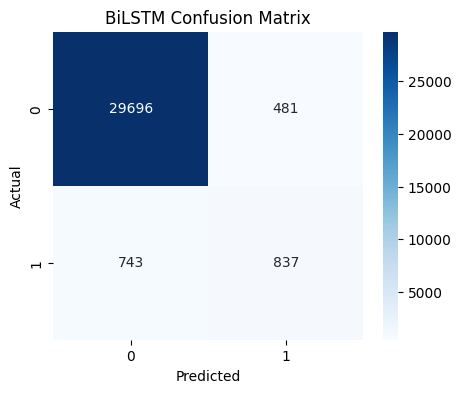

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# ---------- BiLSTM Confusion Matrix ----------
bilstm_preds = (bilstm_model.predict([X1_test, X2_test]) > 0.5).astype(int)
cm_bilstm = confusion_matrix(y_test, bilstm_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Blues')
plt.title("BiLSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



993/993 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step


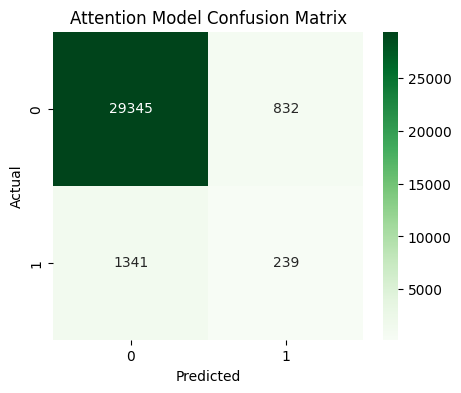

In [43]:
# ---------- Attention Model Confusion Matrix ----------
attention_preds = (attention_model.predict([X1_test, X2_test]) > 0.5).astype(int)
cm_attention = confusion_matrix(y_test, attention_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm_attention, annot=True, fmt='d', cmap='Greens')
plt.title("Attention Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


 Model Performance Comparison
Metric       BiLSTM     Attention 
Accuracy     0.9615     0.9316    
Precision    0.6351     0.2232    
Recall       0.5297     0.1513    
F1-Score     0.5776     0.1803    
ROC-AUC      0.9034     0.7011    


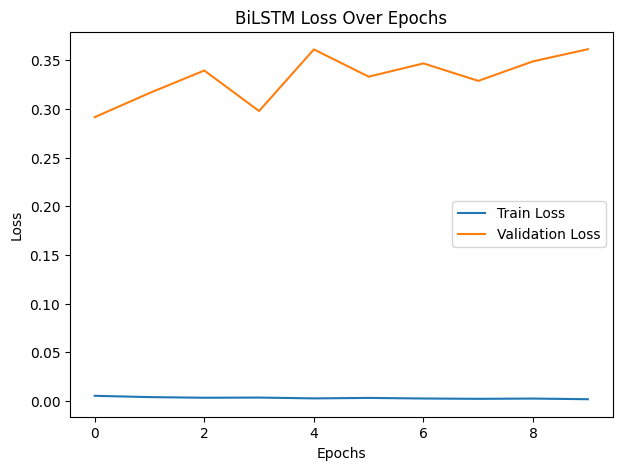

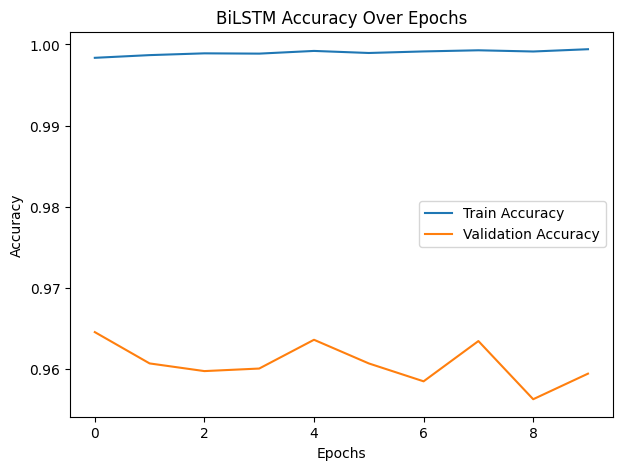

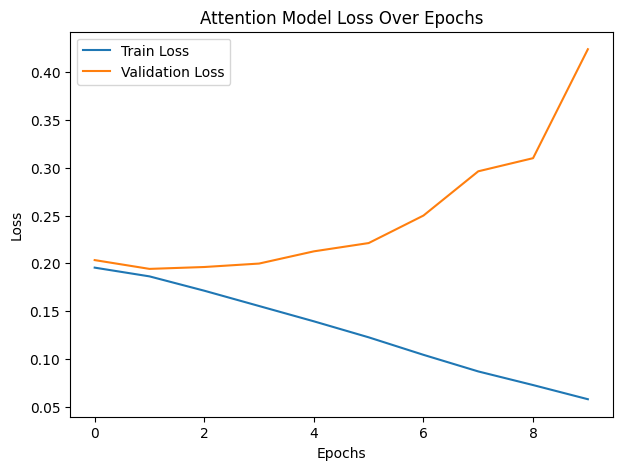

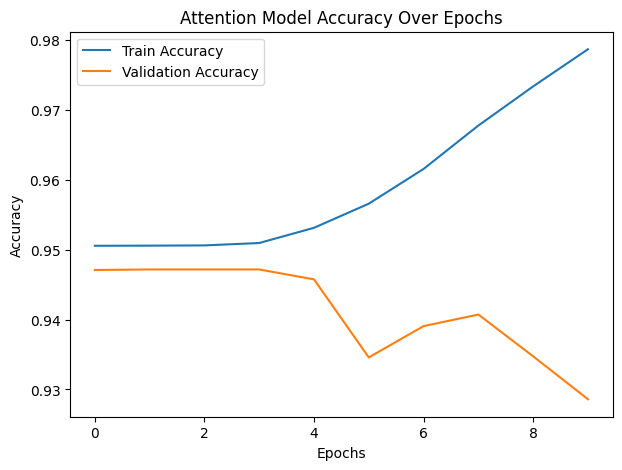

In [44]:
# =====================================
# 11. Print Metrics and Plot Training Curves
# =====================================
# Comparison Table
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
print("\n Model Performance Comparison")
print(f"{'Metric':<12} {'BiLSTM':<10} {'Attention':<10}")
for name, b, a in zip(metrics_names, bilstm_metrics[:5], attention_metrics[:5]):
    print(f"{name:<12} {b:<10.4f} {a:<10.4f}")

# Plotting Function
def plot_training(history, model_name):
    # Loss Plot
    plt.figure(figsize=(7,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy Plot
    plt.figure(figsize=(7,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot separately
plot_training(history_bilstm, 'BiLSTM')
plot_training(history_attention, 'Attention Model')


In [45]:
# Correct and incorrect predictions for BiLSTM
bilstm_preds = bilstm_metrics[5]  # binary predictions
test_pairs_array = X_test  # test pairs array

print("\nSample Correctly Matched Clauses (Predicted 1):")
for i in range(len(y_test)):
    if y_test[i]==1 and bilstm_preds[i]==1:
        print("Clause1:", test_pairs_array[i][0])
        print("Clause2:", test_pairs_array[i][1])
        print("------")
        break

print("\nSample Incorrectly Matched Clauses (Predicted 1, True 0):")
for i in range(len(y_test)):
    if y_test[i]==0 and bilstm_preds[i]==1:
        print("Clause1:", test_pairs_array[i][0])
        print("Clause2:", test_pairs_array[i][1])
        print("------")
        break



Sample Correctly Matched Clauses (Predicted 1):
Clause1: automatic renewal to maintain continuity of the services subscriber’s subscription plan and this agreement automatically renew for one year upon expiration of the term unless subscriber terminates this agreement as provided in section by clicking “i agree” below subscriber gives its consent for automatic renewal of the services this agreement and the applicable fees without further notice unless the agreement is terminated as set forth herein
Clause2: automatic renewal after the initial service agreement period such service shall continue under the terms of the agreement for additional consecutive year renewal service periods for each service component unless either party provides the other written notice that it does not desire to renew such service if you do not wish to renew you must notify mcs in writing within days prior to the last day of the applicable initial or renewal service agreement period
------

Sample Incorrectly